Merged Data Date Range:
2021-12-17 00:00:00 2022-12-30 00:00:00
Train on 10 samples, validate on 249 samples
Epoch 1/100
10/10 - 9s - loss: 437.1960 - val_loss: 667.9058
Epoch 2/100
10/10 - 0s - loss: 437.0178 - val_loss: 667.7586
Epoch 3/100
10/10 - 0s - loss: 436.0759 - val_loss: 667.6111
Epoch 4/100
10/10 - 0s - loss: 434.7848 - val_loss: 667.4632
Epoch 5/100
10/10 - 0s - loss: 434.3693 - val_loss: 667.3144
Epoch 6/100
10/10 - 0s - loss: 432.9075 - val_loss: 667.1636
Epoch 7/100
10/10 - 0s - loss: 432.0866 - val_loss: 667.0106
Epoch 8/100
10/10 - 0s - loss: 430.8914 - val_loss: 666.8547
Epoch 9/100
10/10 - 0s - loss: 429.8885 - val_loss: 666.6950
Epoch 10/100
10/10 - 0s - loss: 429.2010 - val_loss: 666.5315
Epoch 11/100
10/10 - 0s - loss: 428.1119 - val_loss: 666.3635
Epoch 12/100
10/10 - 0s - loss: 427.2398 - val_loss: 666.1908
Epoch 13/100
10/10 - 0s - loss: 426.0426 - val_loss: 666.0124
Epoch 14/100
10/10 - 0s - loss: 425.6959 - val_loss: 665.8282
Epoch 15/100
10/10 - 0s - loss: 

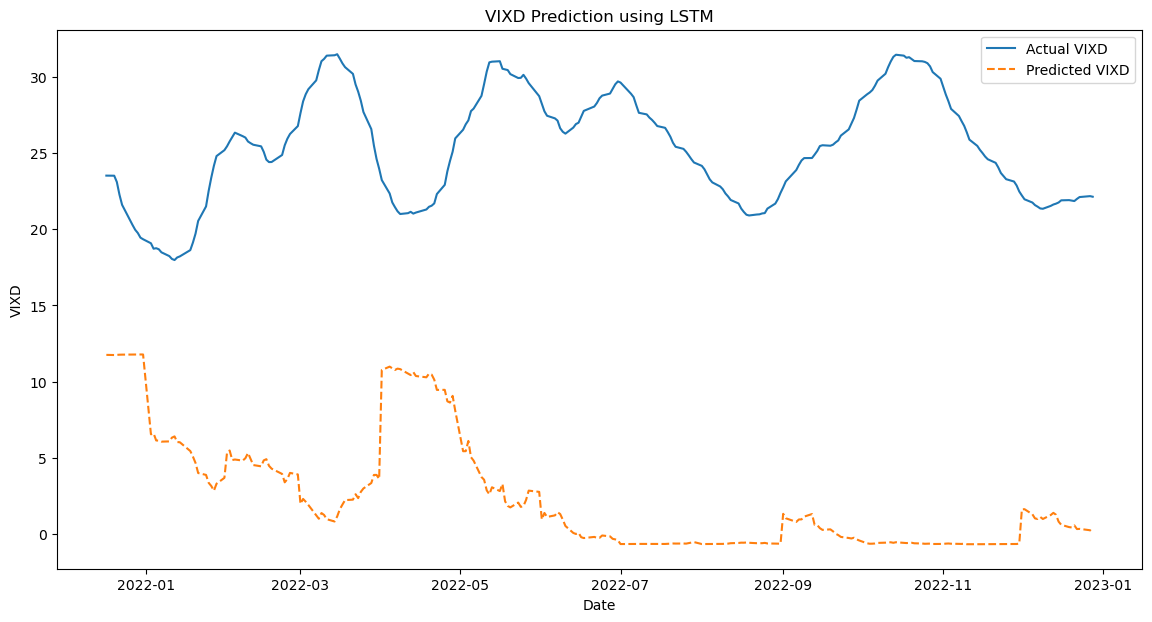

In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# 加载情绪结果文件
finbert_data = pd.read_excel('C:/Users/22749/Desktop/UoG/Fintech/Dissertation/Data/sorted_finbert.xlsx')
textblob_data = pd.read_excel('C:/Users/22749/Desktop/UoG/Fintech/Dissertation/Data/sorted_textblob.xlsx')
vader_data = pd.read_excel('C:/Users/22749/Desktop/UoG/Fintech/Dissertation/Data/sorted_vader.xlsx')

# 加载市场指数数据
spxd_data = pd.read_excel('C:/Users/22749/Desktop/UoG/Fintech/Dissertation/Data/_SPXD.xlsx', sheet_name='Price Data')
spxtrd_data = pd.read_excel('C:/Users/22749/Desktop/UoG/Fintech/Dissertation/Data/_SPXTRD.xlsx', sheet_name='Price Data')
vixd_data = pd.read_excel('C:/Users/22749/Desktop/UoG/Fintech/Dissertation/Data/VIXD.xlsx', sheet_name='Price Data')

# 确保日期列为datetime类型
finbert_data['Date'] = pd.to_datetime(finbert_data['Date'])
textblob_data['Date'] = pd.to_datetime(textblob_data['Date'])
vader_data['Date'] = pd.to_datetime(vader_data['Date'])
spxd_data['Date'] = pd.to_datetime(spxd_data['Date'])
spxtrd_data['Date'] = pd.to_datetime(spxtrd_data['Date'])
vixd_data['Date'] = pd.to_datetime(vixd_data['Date'])

# 将情绪得分扩展到每日
def expand_to_daily(data):
    daily_data = data.set_index('Date').resample('D').ffill().reset_index()
    return daily_data

finbert_data_daily = expand_to_daily(finbert_data)
textblob_data_daily = expand_to_daily(textblob_data)
vader_data_daily = expand_to_daily(vader_data)

# 合并情绪得分数据
sentiment_data = pd.merge(finbert_data_daily, textblob_data_daily, on='Date', how='outer', suffixes=('_finbert', '_textblob'))
sentiment_data = pd.merge(sentiment_data, vader_data_daily, on='Date', how='outer')

# 合并市场指数数据
market_data = pd.merge(spxd_data, spxtrd_data, on='Date', how='outer', suffixes=('_spxd', '_spxtrd'))
market_data = pd.merge(market_data, vixd_data, on='Date', how='outer')

# 合并所有数据
data = pd.merge(sentiment_data, market_data, on='Date', how='outer')
data.set_index('Date', inplace=True)

# 删除所有包含 NaN 值的行
data = data.dropna()

# 检查合并后的日期范围
print("Merged Data Date Range:")
print(data.index.min(), data.index.max())

X = data[['Overall Positive Sentiment', 'Overall Neutral Sentiment', 'Overall Negative Sentiment', 
          'Polarity', 'Subjectivity', 
          'Positive', 'Neutral', 'Negative', 
          'Average_SPXD', 'Close_SPXD', 'Close_SPXTRD', 'Average_SPXTRD']]
y = data['Average_VIXD'].shift(-1)

# 删除目标变量中的NaN值，并对齐特征变量的索引
y = y.dropna()
X = X.loc[y.index]

# 删除与目标变量对齐后的最后一行
X = X.iloc[:-1, :]
y = y.iloc[:-1]

# 调整特征权重
weights = {
    'Overall Positive Sentiment': 0.5,
    'Overall Neutral Sentiment': 0.1,
    'Overall Negative Sentiment': 0.5,
    'Polarity': 0.5,
    'Subjectivity': 0.1,
    'Positive': 0.3,
    'Neutral': 0.1,
    'Negative': 0.3,
    'Average_SPXD': 0.7,
    'Close_SPXD': 0.7,
    'Close_SPXTRD': 0.7,
    'Average_SPXTRD': 0.7
}
for col, weight in weights.items():
    X[col] = X[col] * weight

# 确保特征和目标变量的索引对齐
X = X.loc[y.index]
data = data.loc[y.index]  # 同步删除 data 中的对应行

# 标准化特征
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 拆分训练集和测试集
split_date = '2022-01-01'
split_date = pd.to_datetime(split_date)
X_train = X_scaled[data.index < split_date]
X_test = X_scaled[data.index >= split_date]
y_train = y[data.index < split_date]
y_test = y[data.index >= split_date]

# 重塑数据以适应LSTM输入 [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# 构建LSTM模型
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

# 提前停止
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 训练模型
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), 
                    callbacks=[early_stopping], verbose=2, shuffle=False)

# 评估模型
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

# 可视化预测结果
predicted_vixd = model.predict(X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1])))
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Average_VIXD'], label='Actual VIXD')
plt.plot(data.index, predicted_vixd, label='Predicted VIXD', linestyle='--')
plt.xlabel('Date')
plt.ylabel('VIXD')
plt.title('VIXD Prediction using LSTM')
plt.legend()
plt.show()


In [10]:
# 找出特定列包含 NaN 值的位置
for column in X.columns:
    if X[column].isnull().any():
        print(f"NaN values in column '{column}':")
        print(X[X[column].isnull()])


NaN values in column 'Average_SPXD':
            Overall Positive Sentiment  Overall Neutral Sentiment  \
Date                                                                
2020-01-01                    0.511047                  -0.004092   
2020-01-05                    0.511047                  -0.004092   
2020-01-12                    0.511047                  -0.004092   
2020-01-20                    0.511047                  -0.004092   
2020-01-26                    0.511047                  -0.004092   
...                                ...                        ...   
2022-11-27                    0.490217                  -0.001815   
2022-12-04                    0.546902                   0.009074   
2022-12-11                    0.546902                   0.009074   
2022-12-18                    0.546902                   0.009074   
2022-12-26                    0.546902                   0.009074   

            Overall Negative Sentiment  Polarity  Subjectivity  P

Merged Data Date Range:
2021-12-17 00:00:00 2022-12-30 00:00:00
Train on 155 samples, validate on 52 samples
Epoch 1/1000
155/155 - 5s - loss: 674.2467 - val_loss: 620.0565
Epoch 2/1000
155/155 - 0s - loss: 673.1547 - val_loss: 619.0715
Epoch 3/1000
155/155 - 0s - loss: 671.9892 - val_loss: 617.9917
Epoch 4/1000
155/155 - 0s - loss: 670.7911 - val_loss: 616.7684
Epoch 5/1000
155/155 - 0s - loss: 669.2627 - val_loss: 615.3429
Epoch 6/1000
155/155 - 0s - loss: 667.5444 - val_loss: 613.6394
Epoch 7/1000
155/155 - 0s - loss: 665.0865 - val_loss: 611.5284
Epoch 8/1000
155/155 - 0s - loss: 662.6952 - val_loss: 608.8915
Epoch 9/1000
155/155 - 0s - loss: 659.6162 - val_loss: 605.5683
Epoch 10/1000
155/155 - 0s - loss: 654.8957 - val_loss: 601.2860
Epoch 11/1000
155/155 - 0s - loss: 649.4094 - val_loss: 595.8097
Epoch 12/1000
155/155 - 0s - loss: 641.7796 - val_loss: 588.8424
Epoch 13/1000
155/155 - 0s - loss: 632.3184 - val_loss: 580.0772
Epoch 14/1000
155/155 - 0s - loss: 621.9109 - val_loss:

155/155 - 0s - loss: 15.5707 - val_loss: 9.5866
Epoch 129/1000
155/155 - 0s - loss: 13.9818 - val_loss: 9.5684
Epoch 130/1000
155/155 - 0s - loss: 15.0534 - val_loss: 9.5408
Epoch 131/1000
155/155 - 0s - loss: 14.9839 - val_loss: 9.4977
Epoch 132/1000
155/155 - 0s - loss: 14.5816 - val_loss: 9.4393
Epoch 133/1000
155/155 - 0s - loss: 14.1858 - val_loss: 9.3938
Epoch 134/1000
155/155 - 0s - loss: 14.1846 - val_loss: 9.3482
Epoch 135/1000
155/155 - 0s - loss: 17.0779 - val_loss: 9.2985
Epoch 136/1000
155/155 - 0s - loss: 12.9544 - val_loss: 9.2643
Epoch 137/1000
155/155 - 0s - loss: 13.1241 - val_loss: 9.2194
Epoch 138/1000
155/155 - 0s - loss: 11.5563 - val_loss: 9.1832
Epoch 139/1000
155/155 - 0s - loss: 14.0000 - val_loss: 9.1381
Epoch 140/1000
155/155 - 0s - loss: 13.8224 - val_loss: 9.0891
Epoch 141/1000
155/155 - 0s - loss: 13.3411 - val_loss: 9.0496
Epoch 142/1000
155/155 - 0s - loss: 12.7278 - val_loss: 9.0182
Epoch 143/1000
155/155 - 0s - loss: 14.2336 - val_loss: 8.9772
Epoch 1

Epoch 259/1000
155/155 - 0s - loss: 10.1344 - val_loss: 5.2596
Epoch 260/1000
155/155 - 0s - loss: 9.5586 - val_loss: 5.2696
Epoch 261/1000
155/155 - 0s - loss: 9.5053 - val_loss: 5.2823
Epoch 262/1000
155/155 - 0s - loss: 10.3358 - val_loss: 5.2919
Epoch 263/1000
155/155 - 0s - loss: 8.0315 - val_loss: 5.2835
Epoch 264/1000
155/155 - 0s - loss: 8.3170 - val_loss: 5.2766
Epoch 265/1000
155/155 - 0s - loss: 9.1775 - val_loss: 5.2671
Epoch 266/1000
155/155 - 0s - loss: 8.3761 - val_loss: 5.2573
Epoch 267/1000
155/155 - 0s - loss: 10.4473 - val_loss: 5.2512
Epoch 268/1000
155/155 - 0s - loss: 8.4954 - val_loss: 5.2523
Epoch 269/1000
155/155 - 0s - loss: 8.9456 - val_loss: 5.2566
Epoch 270/1000
155/155 - 0s - loss: 10.1323 - val_loss: 5.2581
Epoch 271/1000
155/155 - 0s - loss: 7.7785 - val_loss: 5.2553
Epoch 272/1000
155/155 - 0s - loss: 7.4608 - val_loss: 5.2489
Epoch 273/1000
155/155 - 0s - loss: 8.5414 - val_loss: 5.2398
Epoch 274/1000
155/155 - 0s - loss: 8.9668 - val_loss: 5.2306
Epoc

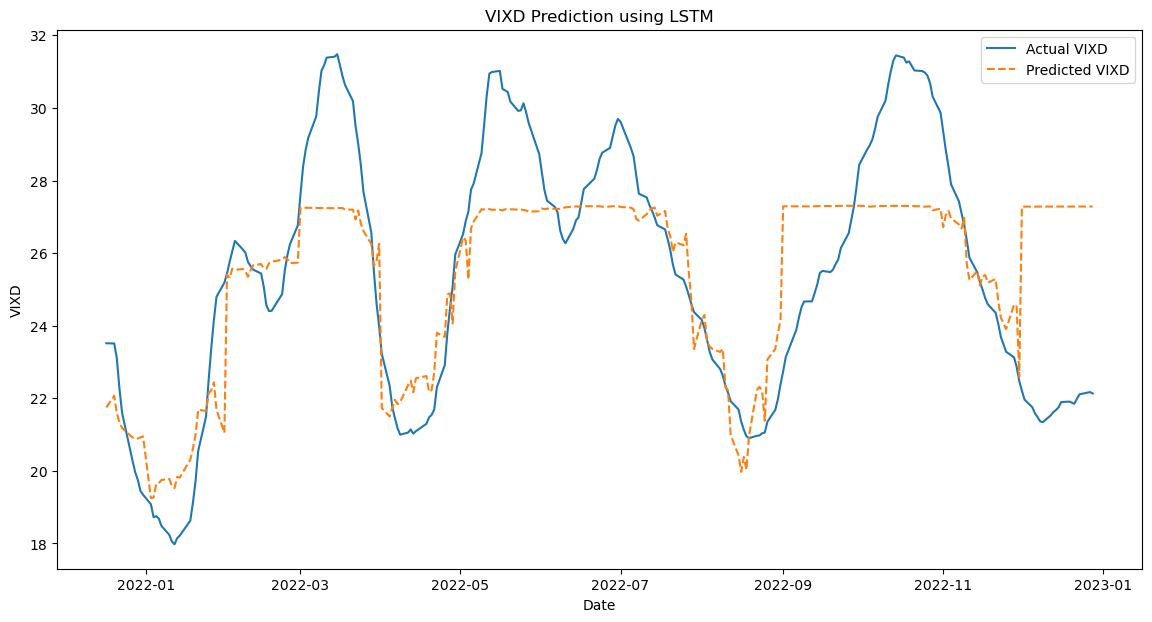

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# 加载情绪结果文件
finbert_data = pd.read_excel('C:/Users/22749/Desktop/UoG/Fintech/Dissertation/Data/sorted_finbert.xlsx')
textblob_data = pd.read_excel('C:/Users/22749/Desktop/UoG/Fintech/Dissertation/Data/sorted_textblob.xlsx')
vader_data = pd.read_excel('C:/Users/22749/Desktop/UoG/Fintech/Dissertation/Data/sorted_vader.xlsx')

# 加载市场指数数据
spxd_data = pd.read_excel('C:/Users/22749/Desktop/UoG/Fintech/Dissertation/Data/_SPXD.xlsx', sheet_name='Price Data')
spxtrd_data = pd.read_excel('C:/Users/22749/Desktop/UoG/Fintech/Dissertation/Data/_SPXTRD.xlsx', sheet_name='Price Data')
vixd_data = pd.read_excel('C:/Users/22749/Desktop/UoG/Fintech/Dissertation/Data/VIXD.xlsx', sheet_name='Price Data')

# 确保日期列为datetime类型
finbert_data['Date'] = pd.to_datetime(finbert_data['Date'])
textblob_data['Date'] = pd.to_datetime(textblob_data['Date'])
vader_data['Date'] = pd.to_datetime(vader_data['Date'])
spxd_data['Date'] = pd.to_datetime(spxd_data['Date'])
spxtrd_data['Date'] = pd.to_datetime(spxtrd_data['Date'])
vixd_data['Date'] = pd.to_datetime(vixd_data['Date'])

# 将情绪得分扩展到每日
def expand_to_daily(data):
    daily_data = data.set_index('Date').resample('D').ffill().reset_index()
    return daily_data

finbert_data_daily = expand_to_daily(finbert_data)
textblob_data_daily = expand_to_daily(textblob_data)
vader_data_daily = expand_to_daily(vader_data)

# 合并情绪得分数据
sentiment_data = pd.merge(finbert_data_daily, textblob_data_daily, on='Date', how='outer', suffixes=('_finbert', '_textblob'))
sentiment_data = pd.merge(sentiment_data, vader_data_daily, on='Date', how='outer')

# 合并市场指数数据
market_data = pd.merge(spxd_data, spxtrd_data, on='Date', how='outer', suffixes=('_spxd', '_spxtrd'))
market_data = pd.merge(market_data, vixd_data, on='Date', how='outer')

# 合并所有数据
data = pd.merge(sentiment_data, market_data, on='Date', how='outer')
data.set_index('Date', inplace=True)

# 删除所有包含 NaN 值的行
data = data.dropna()

# 检查合并后的日期范围
print("Merged Data Date Range:")
print(data.index.min(), data.index.max())

X = data[['Overall Positive Sentiment', 'Overall Neutral Sentiment', 'Overall Negative Sentiment', 
          'Polarity', 'Subjectivity', 
          'Positive', 'Neutral', 'Negative', 
          'Average_SPXD', 'Close_SPXD', 'Close_SPXTRD', 'Average_SPXTRD']]
y = data['Average_VIXD'].shift(-1)

# 删除目标变量中的NaN值，并对齐特征变量的索引
y = y.dropna()
X = X.loc[y.index]

# 删除与目标变量对齐后的最后一行
X = X.iloc[:-1, :]
y = y.iloc[:-1]

# 调整特征权重
weights = {
    'Overall Positive Sentiment': 0.5,
    'Overall Neutral Sentiment': 0.1,
    'Overall Negative Sentiment': 0.5,
    'Polarity': 0.5,
    'Subjectivity': 0.1,
    'Positive': 0.3,
    'Neutral': 0.1,
    'Negative': 0.3,
    'Average_SPXD': 0.7,
    'Close_SPXD': 0.7,
    'Close_SPXTRD': 0.7,
    'Average_SPXTRD': 0.7
}
for col, weight in weights.items():
    X[col] = X[col] * weight

# 确保特征和目标变量的索引对齐
X = X.loc[y.index]
data = data.loc[y.index]  # 同步删除 data 中的对应行

# 标准化特征
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 拆分训练集、验证集和测试集
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# 重塑数据以适应LSTM输入 [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# 构建LSTM模型
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

# 提前停止
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

# 训练模型
history = model.fit(X_train, y_train, epochs=1000, batch_size=32, validation_data=(X_val, y_val), 
                    callbacks=[early_stopping], verbose=2, shuffle=False)

# 评估模型
y_val_pred = model.predict(X_val)
val_mse = mean_squared_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)

print(f'Validation Mean Squared Error: {val_mse}')
print(f'Validation R^2 Score: {val_r2}')

y_test_pred = model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f'Test Mean Squared Error: {test_mse}')
print(f'Test R^2 Score: {test_r2}')

# 可视化预测结果
predicted_vixd = model.predict(X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1])))
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Average_VIXD'], label='Actual VIXD')
plt.plot(data.index, predicted_vixd, label='Predicted VIXD', linestyle='--')
plt.xlabel('Date')
plt.ylabel('VIXD')
plt.title('VIXD Prediction using LSTM')
plt.legend()
plt.show()
